# _Traffic Sign Recognizer - CNN_


## Importing Required Libraries


In [1]:
import os
import traceback
import random

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
from matplotlib.image import imread

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, schedules
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras import backend as K

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

keras.utils.set_random_seed(42)

In [2]:
import tensorflow as tf
print("cuDNN version:", tf.test.is_built_with_cuda())

cuDNN version: False


## Assigning Path for Dataset

In [3]:
data_dir = "dataset"
train_path = "dataset/Train"
test_path = "dataset/Test"

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes


In [4]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [5]:
# Label Overview
classes = {
    0: "Speed limit 20",
    1: "Speed limit 30",
    2: "Speed limit 50",
    3: "Speed limit 60",
    4: "Speed limit 70",
    5: "Speed limit 80",
    6: "End of speed limit 80",
    7: "Speed limit 100",
    8: "Speed limit 120",
    9: "No passing",
    10: "No passing for over 3.5 tons",
    11: "Right-of-way at intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "> 3.5 tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve left",
    20: "Dangerous curve right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End speed + passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End no passing > 3.5 tons",
}

## Visualizing The Dataset


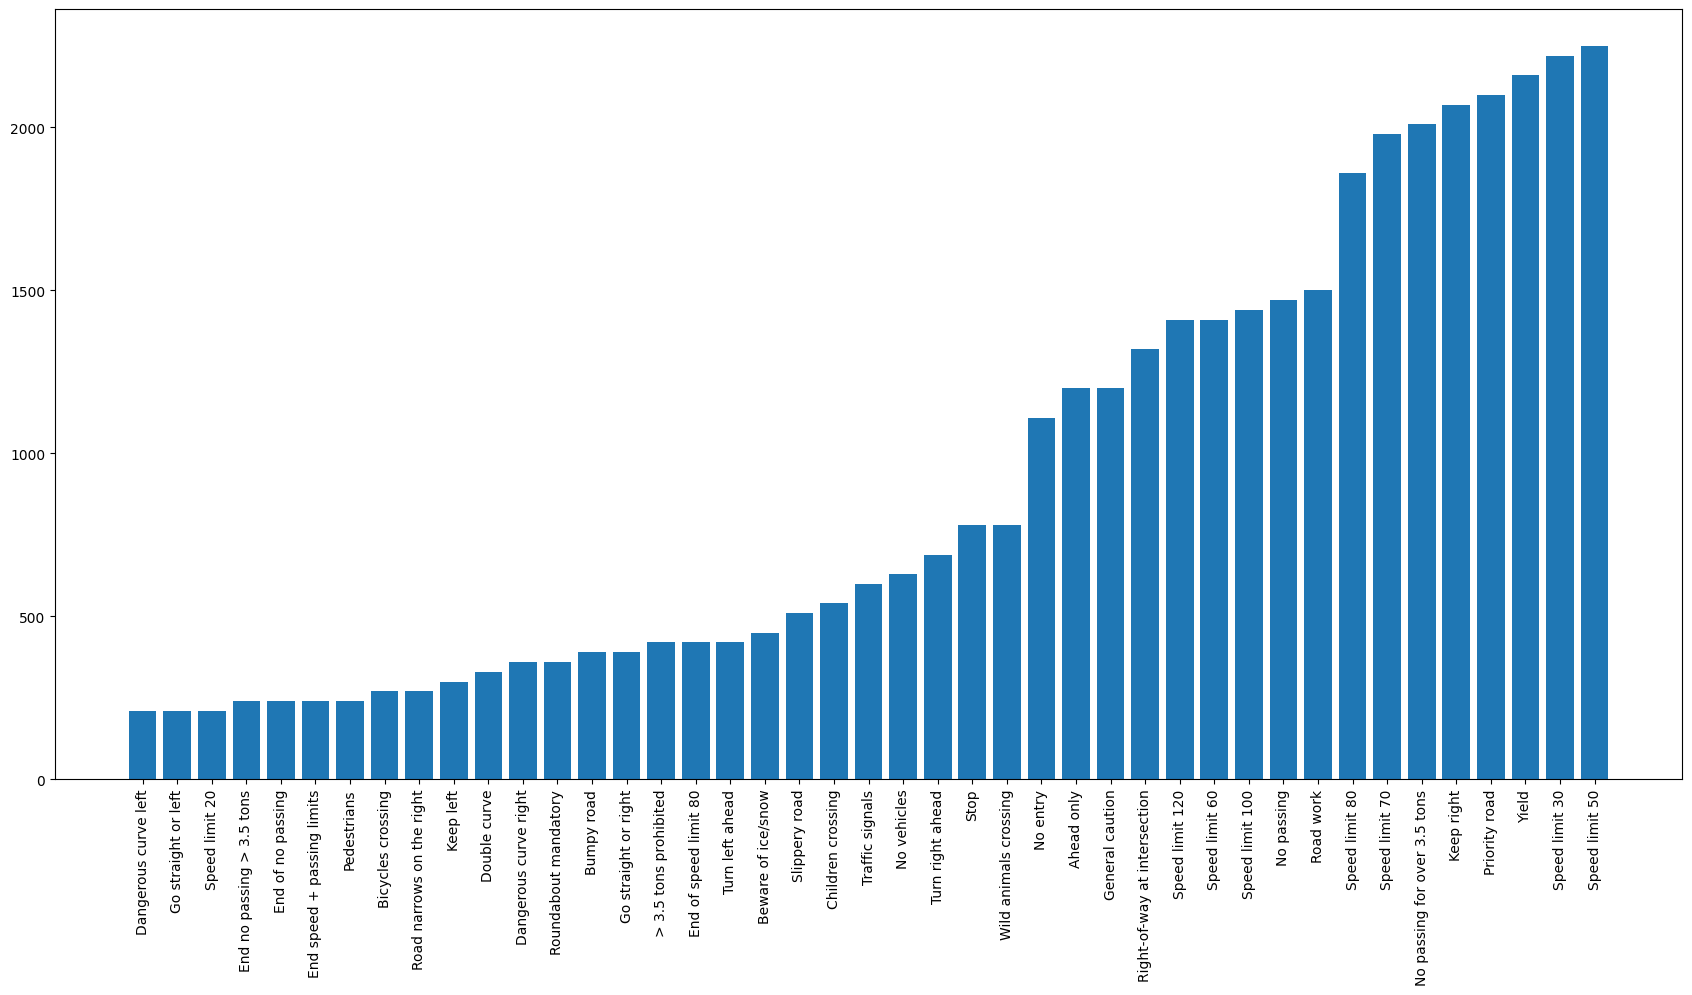

In [6]:
folders = os.listdir(train_path)

train_number = []
class_num = []
for folder in folders:
    train_files = os.listdir(train_path + "/" + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [list(tuple) for tuple in tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21, 10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation="vertical")
plt.show()

In [7]:
sum(train_number)

39209

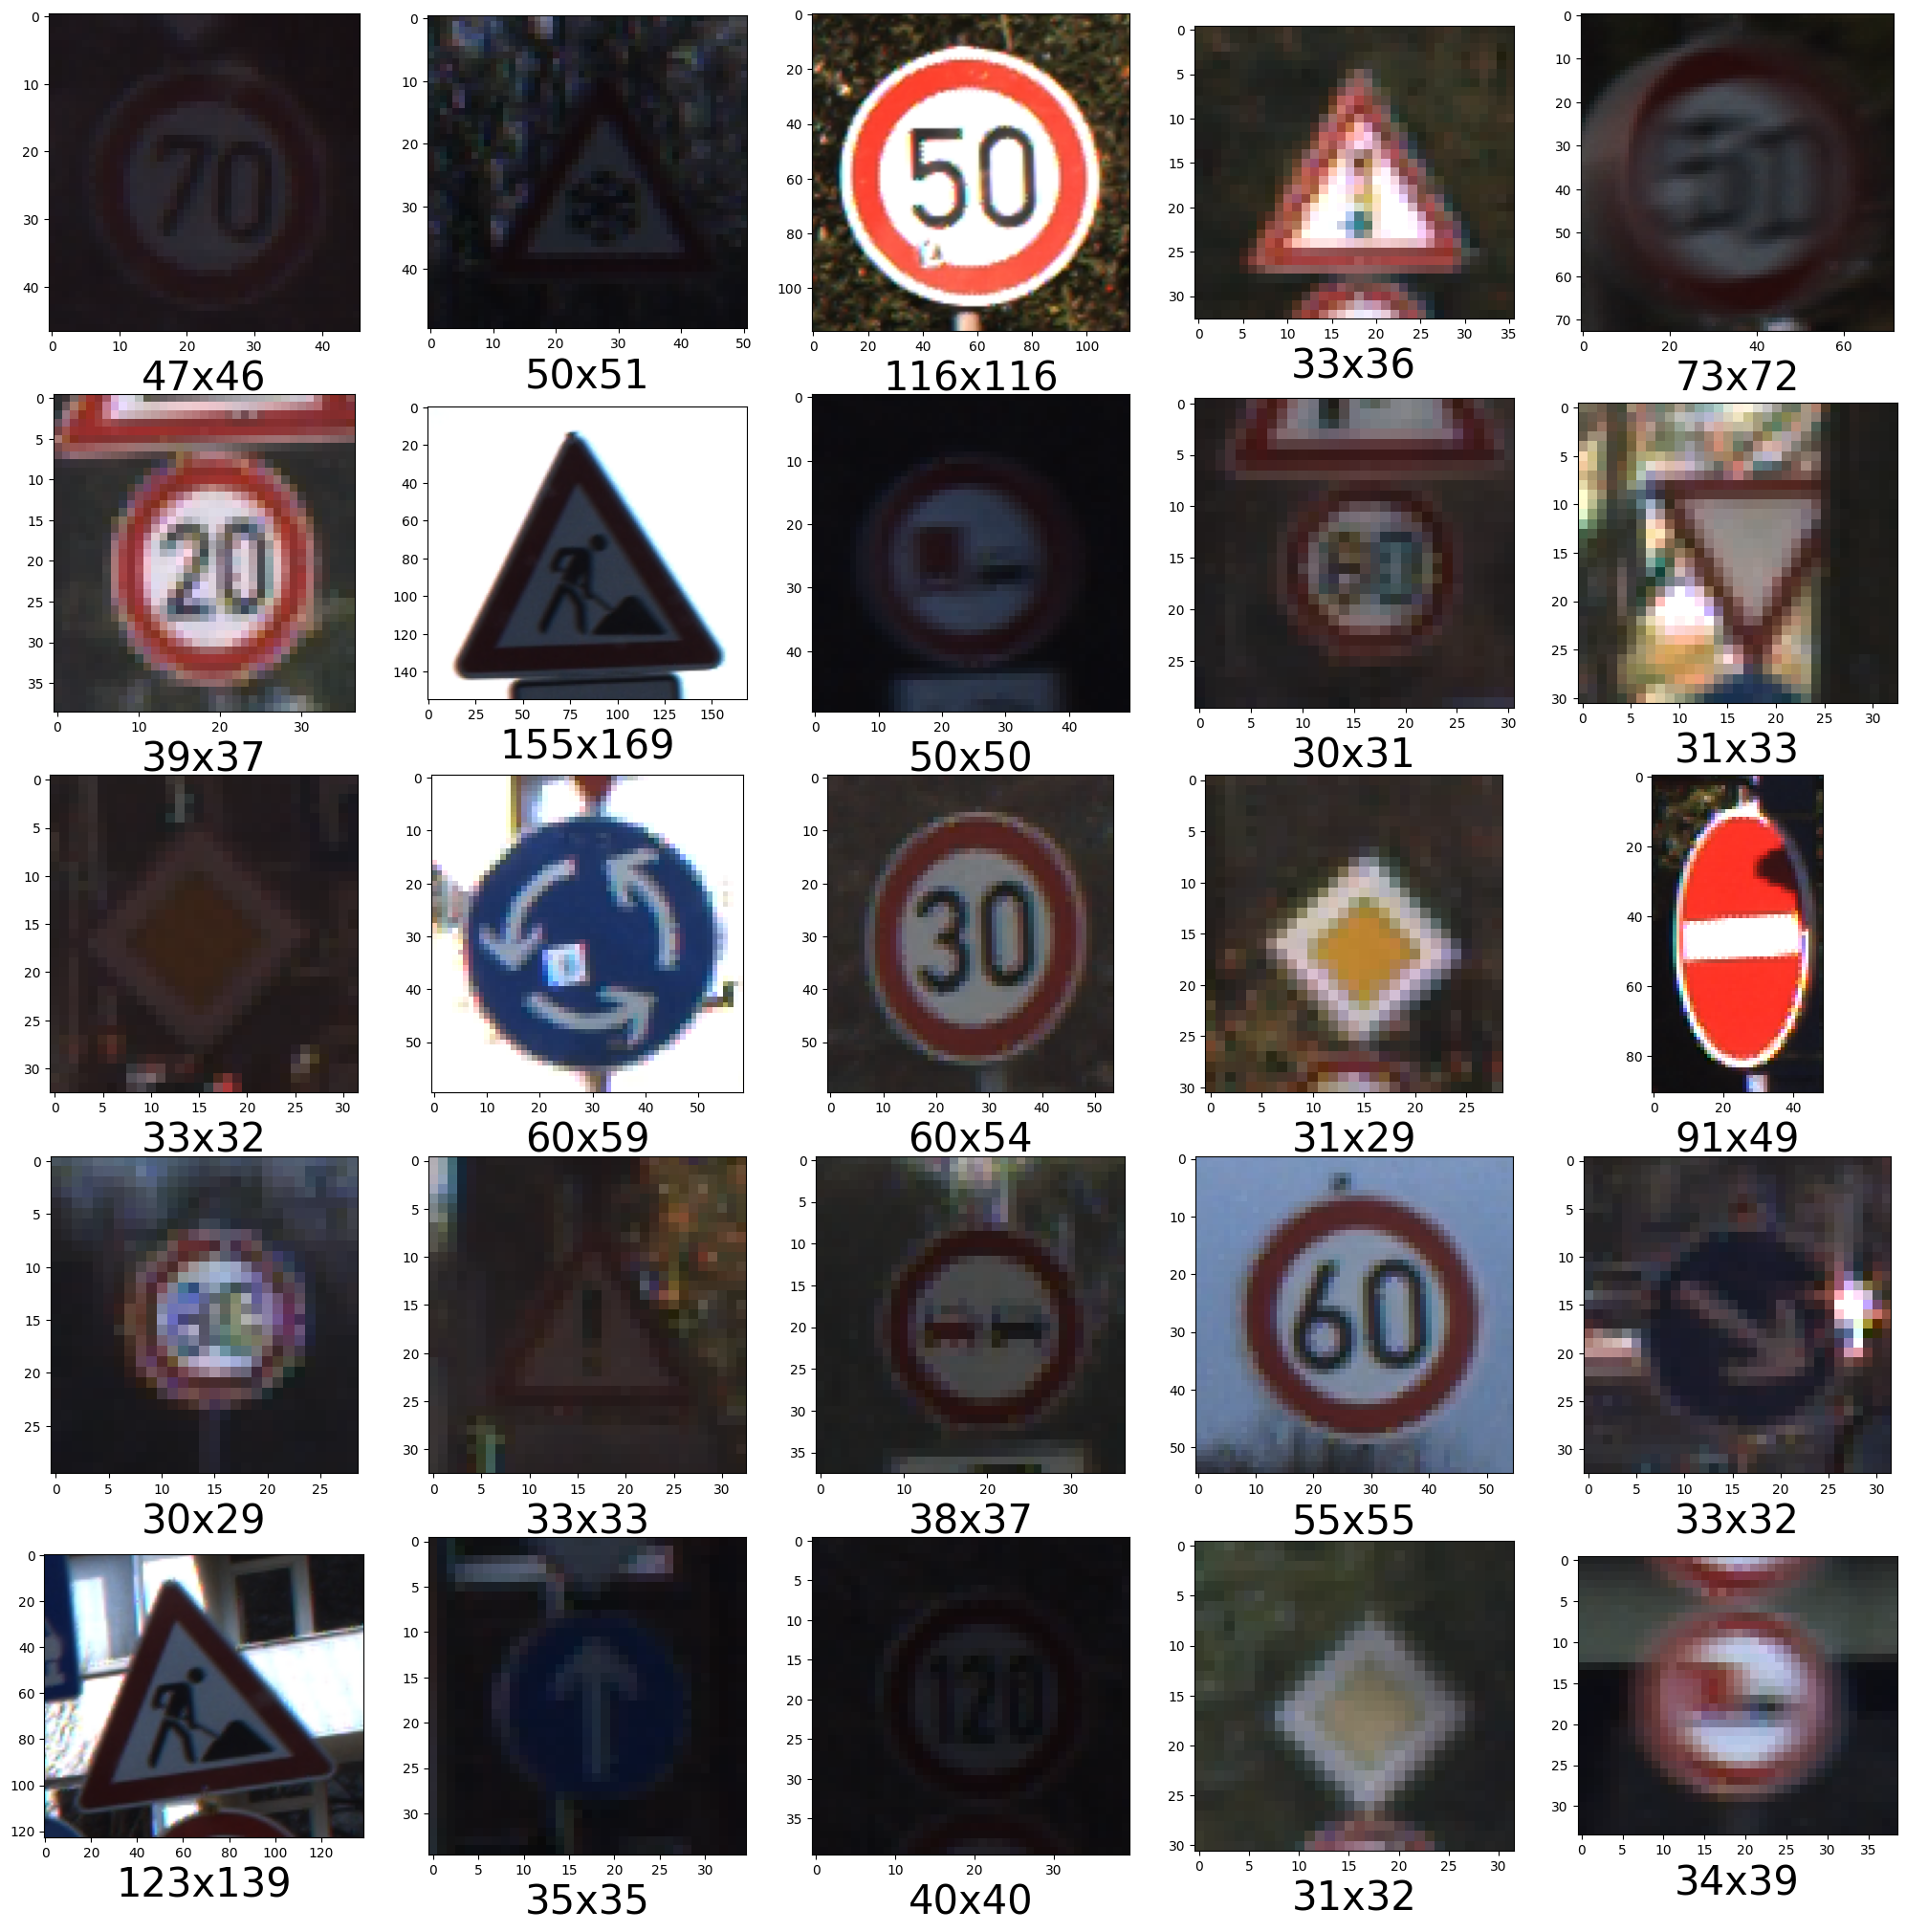

In [8]:
# Visualizing 25 random images from test data

test = pd.read_csv(data_dir + "/Test.csv")
test_img_names = test["Path"].values
test_imgs = []

for i in range(25):
    test_imgs.append(imread(os.path.join(data_dir, random.choice(test_img_names))))


def show_imgs(imgs, size, n):
    plt.figure(figsize=size)
    for i, img in enumerate(imgs):
        plt.subplot(n, n, i + 1)
        plt.imshow(img)
        plt.grid(visible=False)
        plt.xlabel(
            "{}x{}".format(img.shape[0], img.shape[1]), fontsize=30
        )  # height x width


show_imgs(test_imgs, (25, 25), 5)

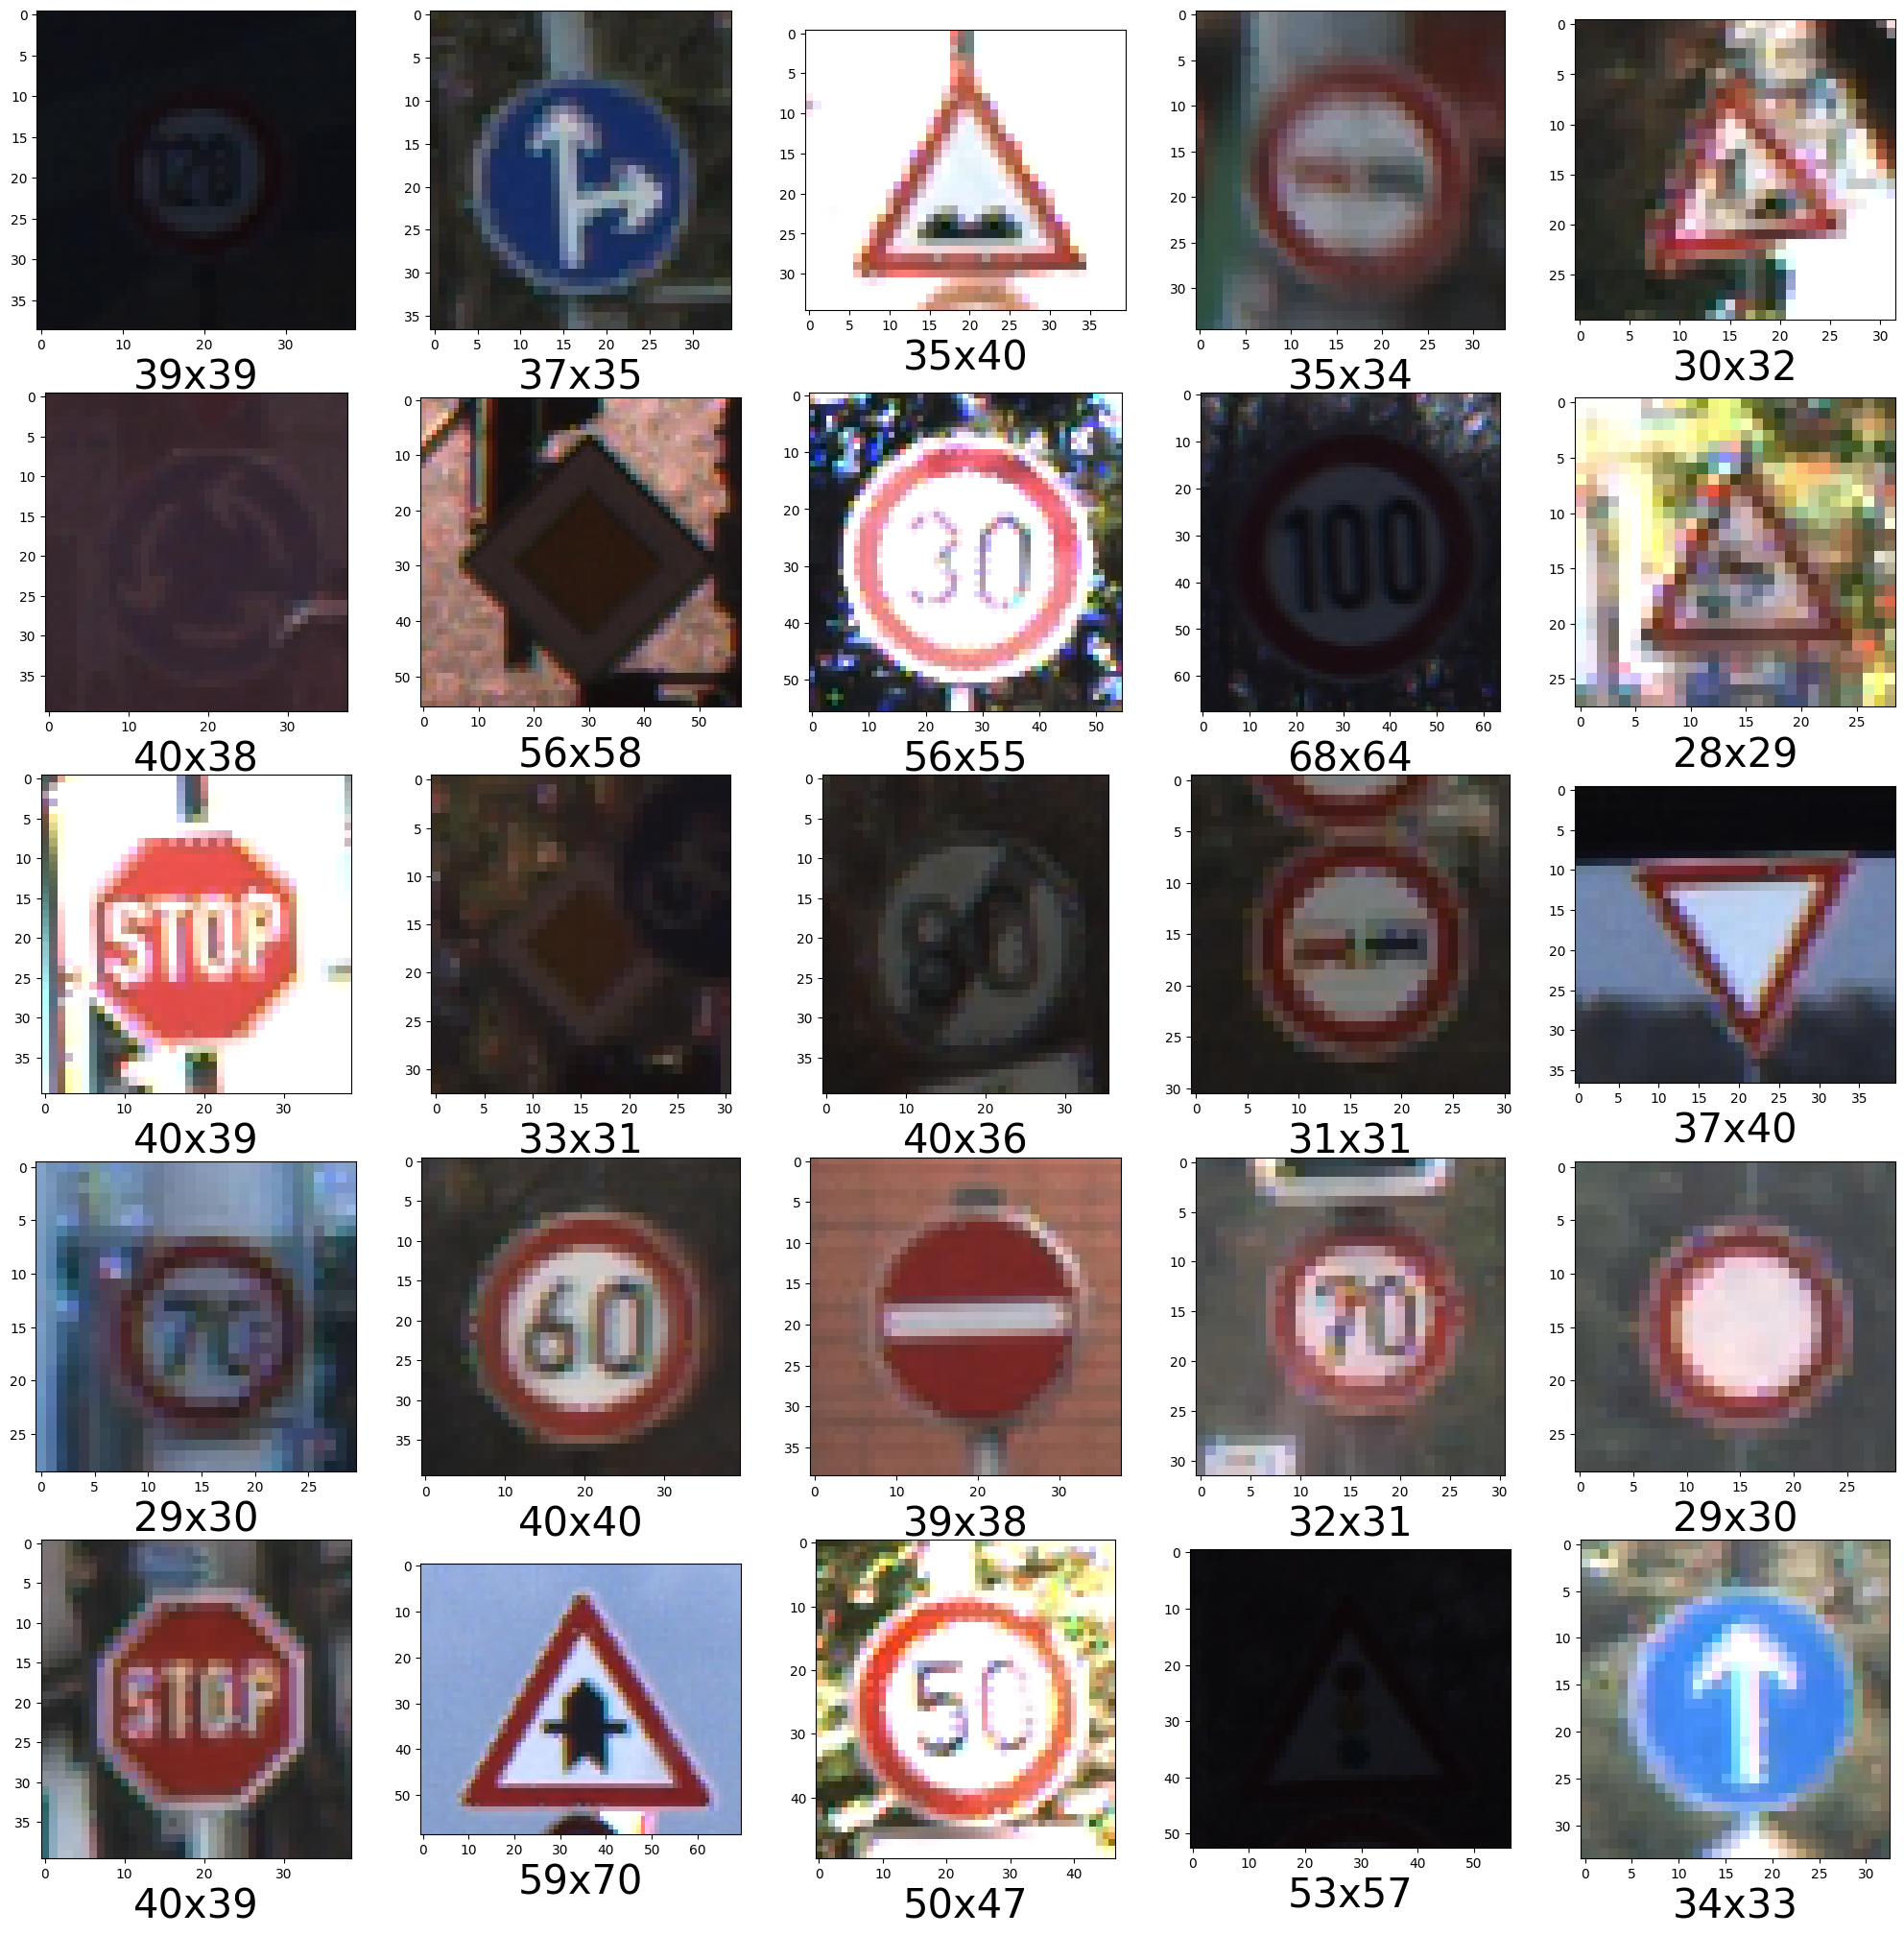

In [9]:
# Visualizing Raw train data before preprocessing
train_data = pd.read_csv(data_dir + "/Train.csv")
train_img_names = train_data["Path"].values
train_imgs = []
for i in range(25):
    train_imgs.append(imread(os.path.join(data_dir, random.choice(train_img_names))))
show_imgs(train_imgs, (25, 25), 5)

## Collecting and preprocessing the Training Data


In [10]:
def load_data_from_csv(csv_file, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    imgs = []
    labels = []
    info_csv = pd.read_csv(f"{data_dir}/{csv_file}")
    for row in info_csv.iterrows():
        try:
            img_path = f"{data_dir}/{row[1].Path}"
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # work with matplotlib imshow()
            img = cv2.resize(img, img_size)
            imgs.append(np.array(img))
            labels.append(row[1].ClassId)
        except Exception:
            print(f"Error in {img_path}")
            traceback.print_exc()
            return
    imgs = np.array(imgs)
    labels = np.array(labels)
    return imgs, labels


# Changing the list to numpy array
image_data, image_labels = load_data_from_csv("Train.csv")

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the training data


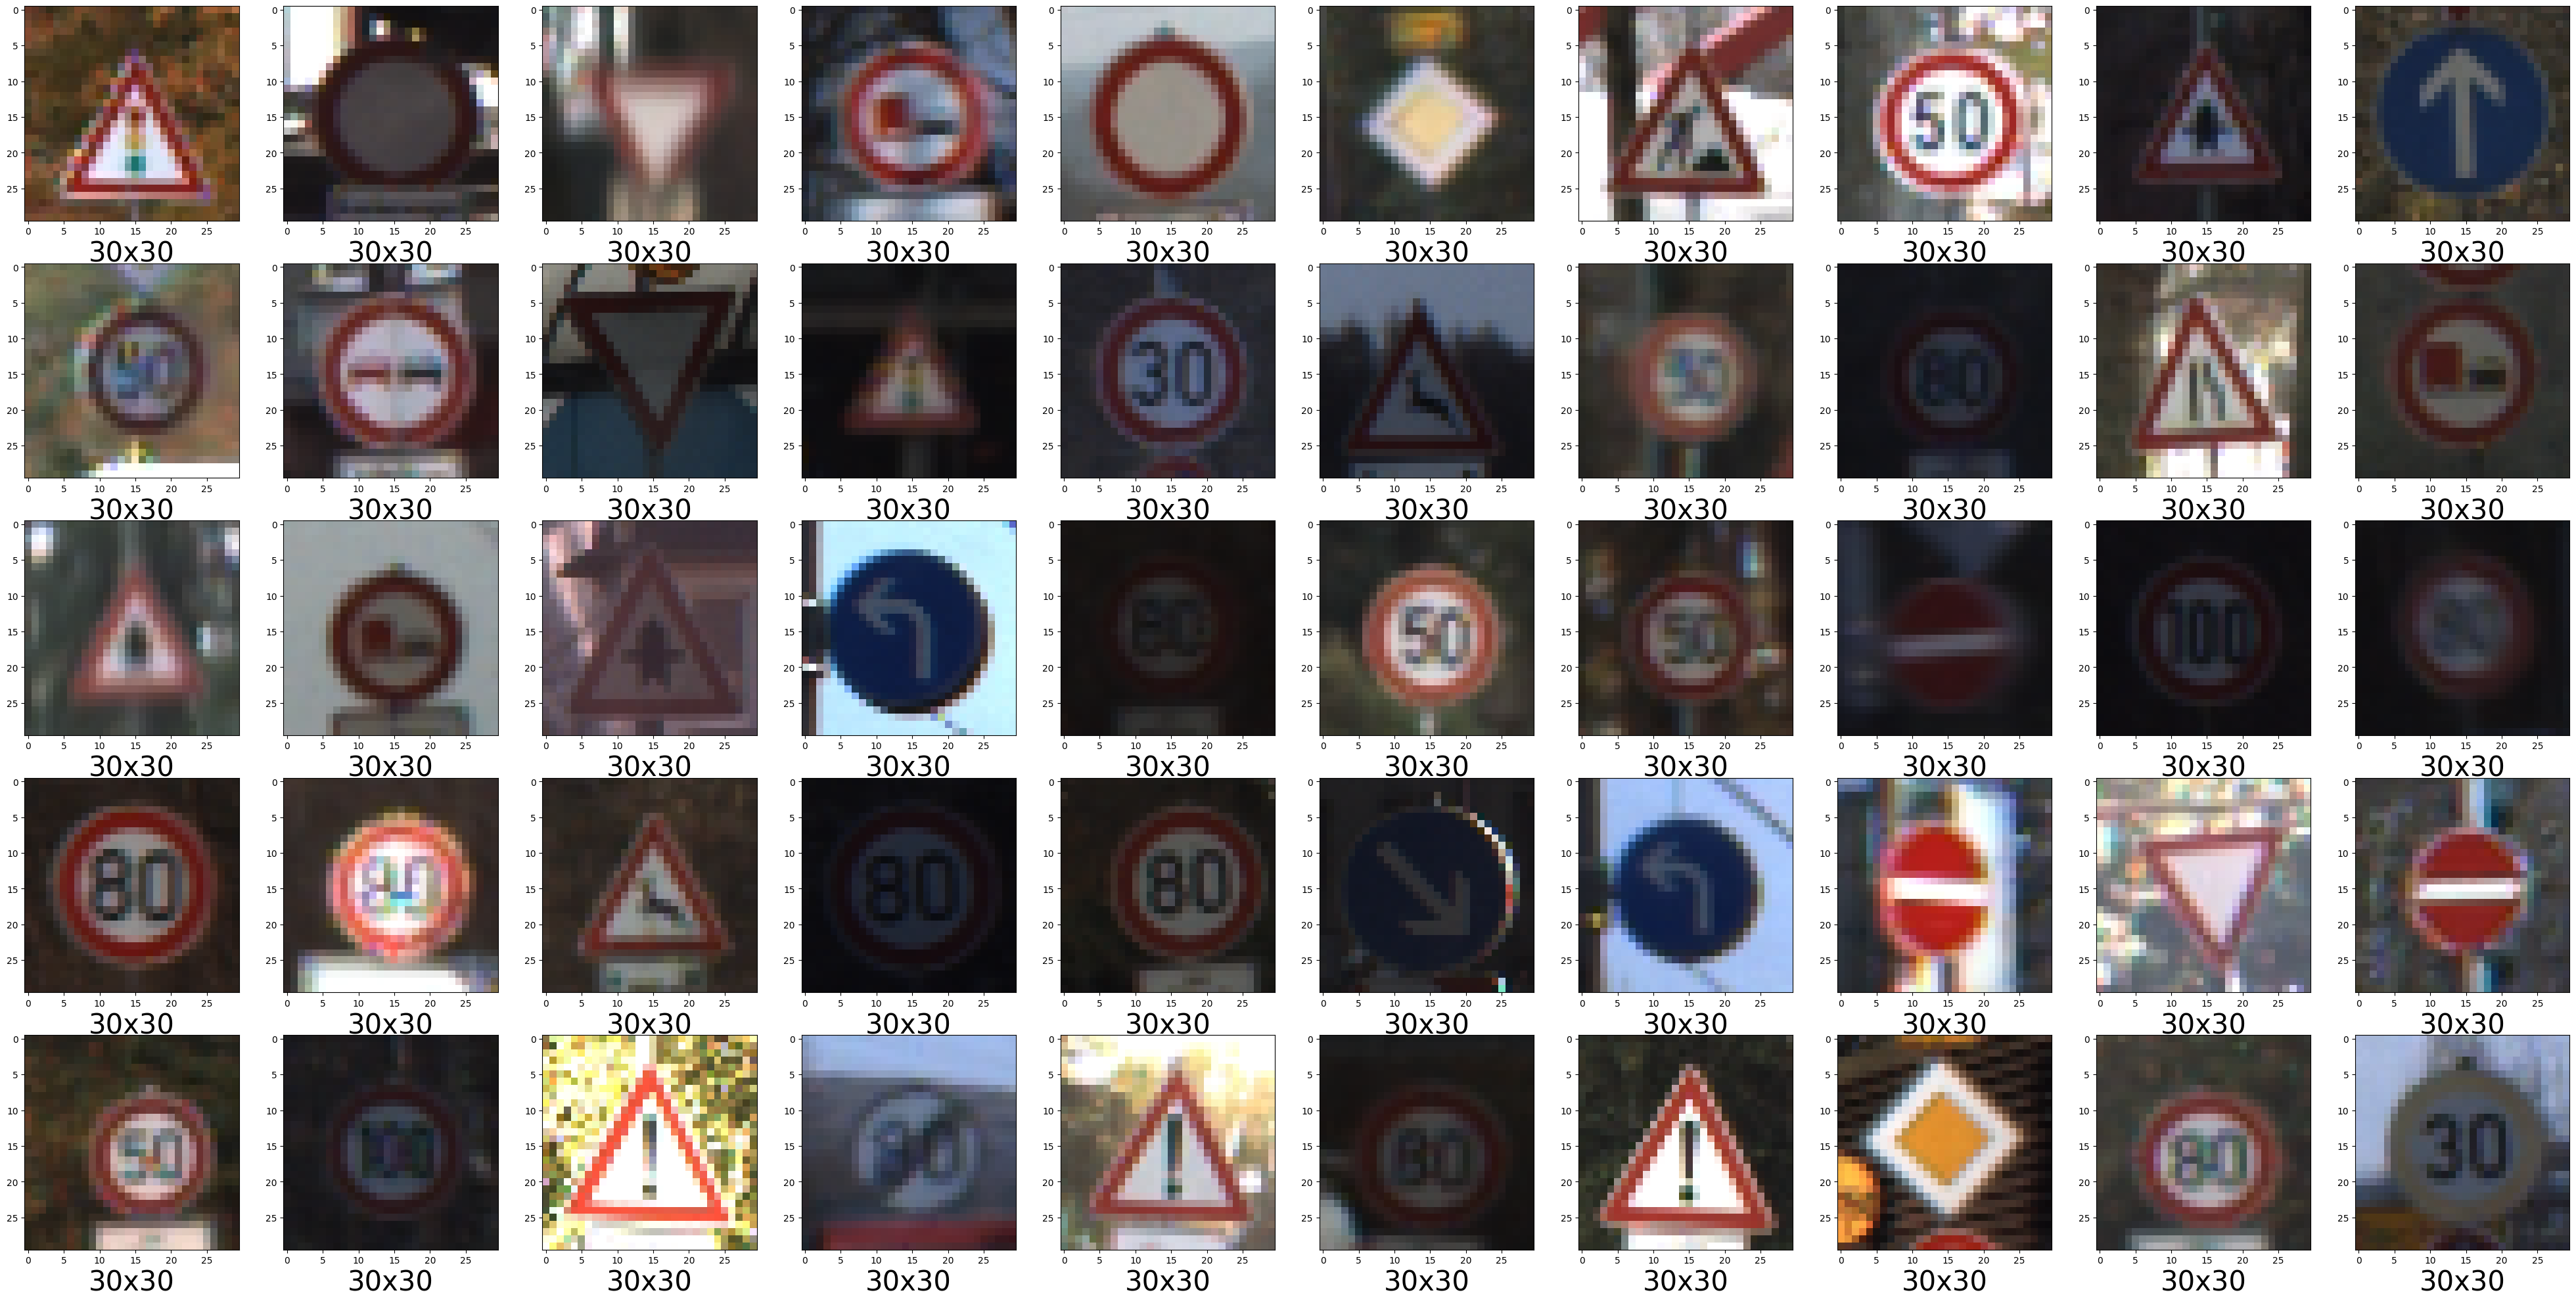

In [11]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]
show_imgs(image_data[0:50], (50, 50), 10)

## Splitting the data into train and validation set


In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    image_data, image_labels, test_size=0.3, random_state=42, shuffle=True
)

X_train = X_train / 255
X_val = X_val / 255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding the labels


In [13]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


# Epochs, batch size and train size


In [14]:
epochs = 11
batch_size = 32
train_size = len(y_train)

## Augmenting the data and training the model


We create an augmentation of each image. To illustrate, look at the pictures below (number 0, 1, 2, ... are timestamps), the augmentation flow will create many different image base on the original one.


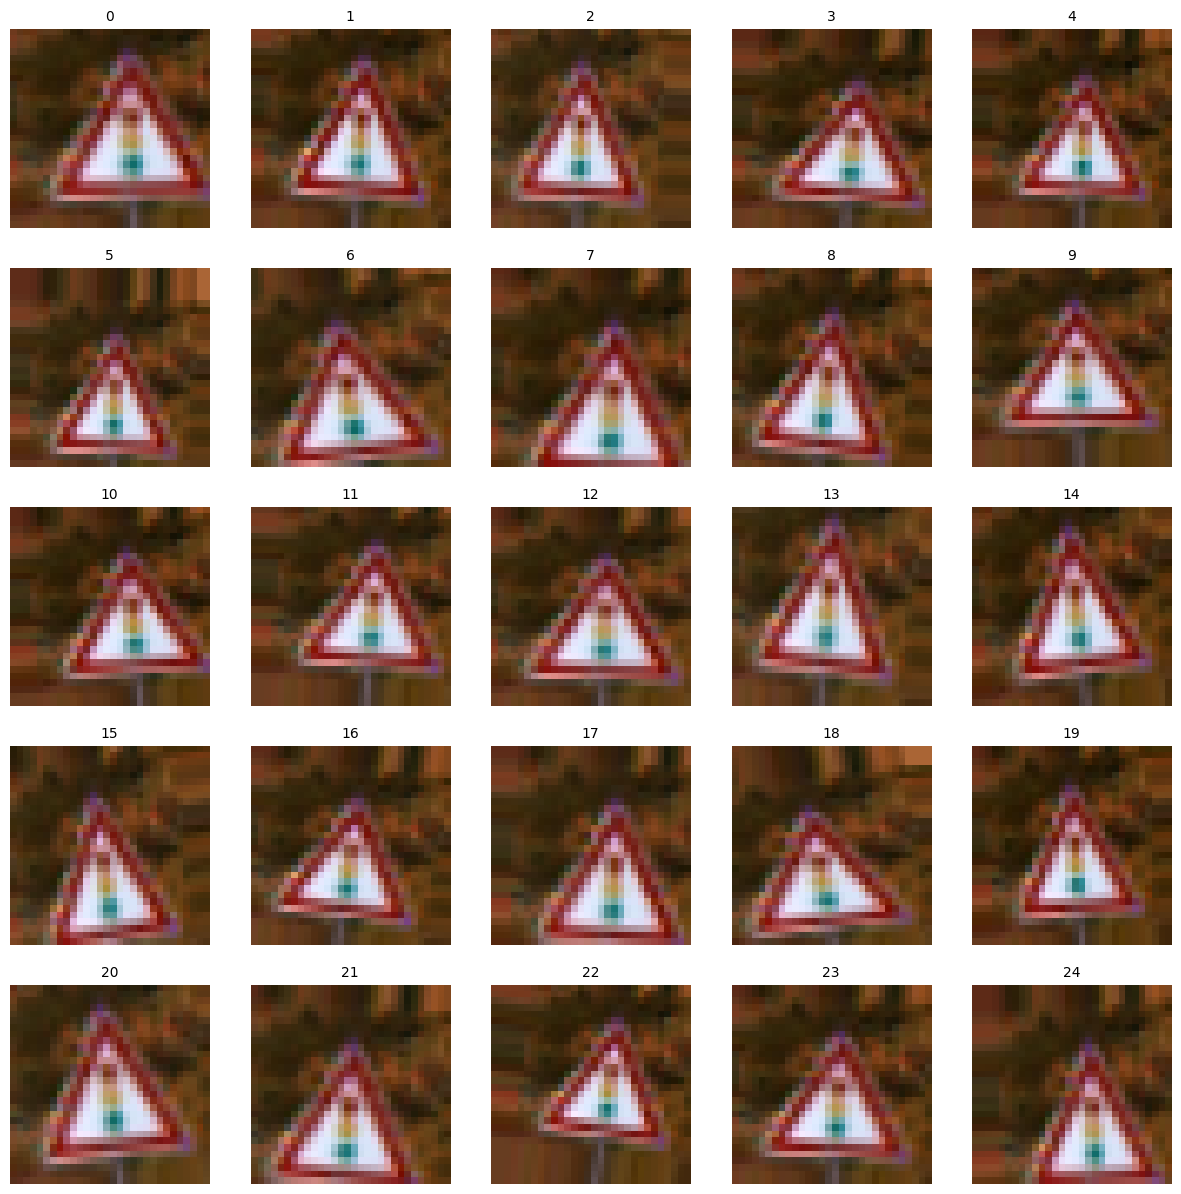

In [15]:
from keras.preprocessing.image import array_to_img, img_to_array

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest",
)


def illustrate_aug():
    # Load and preprocess an example image
    x = img_to_array(image_data[0])
    x = x.reshape((1,) + x.shape)

    # Generate augmented images
    num_augmented_images = 25
    fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(15, 15))

    for i in range(5):
        for j in range(5):
            augmented_image = array_to_img(aug.flow(x, batch_size=batch_size)[0][0])
            axes[i, j].imshow(augmented_image)
            axes[i, j].axis("off")
            axes[i, j].set_title(f"{i*5 + j}", fontsize=10)

        if i == num_augmented_images:
            break

    plt.show()


illustrate_aug()

# Model

## Model Architecture

In [16]:
def create_model(
    base_filters=32,
    kernel_size=(3, 3),
    drop_rate=0.5,
    units=None,
    pool_size=(2, 2),
    padding="same",
):
    if units == None:
        units = base_filters * 4 * 8

    seq = [
        Conv2D(
            filters=base_filters,
            kernel_size=kernel_size,
            activation="relu",
            input_shape=(IMG_HEIGHT, IMG_WIDTH, channels),
            padding=padding,
        ),

        Conv2D(
            filters=base_filters * 2,
            kernel_size=kernel_size,
            activation="relu",
            padding=padding,
        ),
        MaxPool2D(pool_size=pool_size),
        BatchNormalization(axis=-1),
        Conv2D(
            filters=base_filters * 4,
            kernel_size=kernel_size,
            activation="relu",
            padding=padding,
        ),
        Conv2D(
            filters=base_filters * 8,
            kernel_size=kernel_size,
            activation="relu",
            padding=padding,
        ),
        MaxPool2D(pool_size=pool_size),
        BatchNormalization(axis=-1),
        Flatten(),
        Dense(units, activation="relu"),
        BatchNormalization(),
        Dropout(rate=drop_rate),
        Dense(43, activation="softmax"),
    ]

    return Sequential(seq)
    

## Optimizer using learning rate scheduler


In [17]:
def adam_with_decay_lr(initial_learning_rate, final_learning_rate):
    learning_rate_decay_factor = (final_learning_rate / initial_learning_rate) ** (
        1 / epochs
    )
    steps_per_epoch = int(train_size / batch_size)
    lr_schedule = schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=steps_per_epoch,
        decay_rate=learning_rate_decay_factor,
        staircase=True,
    )

    opt = Adam(learning_rate=lr_schedule)
    return opt

## Compile and fit the model


In [18]:
from keras import backend as K

def compile_and_fit(model):
    model.compile(loss="categorical_crossentropy", optimizer=adam_with_decay_lr(0.001, 0.000001), metrics=["accuracy"])
    history = model.fit(
        aug.flow(X_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(X_val, y_val),
    )
    K.clear_session()
    return history

def plot_history(h, title):
    pd.DataFrame(h.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.title(title)
    plt.show()

## Train model


### Load test data

In [19]:
X_test, labels = load_data_from_csv("Test.csv")
X_test = X_test / 255

def accuracy(model):
    pred = np.argmax(model.predict(X_test), axis=1)
    model_accuracy = accuracy_score(labels, pred)
    return model_accuracy*100

### Decide hyperprameters for the best model


In [20]:
kernel_sizes = [(3, 3), (5, 5)]
n_filters = [32, 64, 128]
dropout_rates = [0.5, 0.4, 0.3, 0.2]
units = [512, 1024, 2048, 4096]

### Decide kernel size

The result is almost the same but (3,3) is better because it takes less resources to calculate

### Decide filters

Increasing filters usually make accuracy higher but the performance will be much more slower. It is a trade-off, so we need to choose appropriate number to create a efficient model.

### Decide dropout rate

### Decide units in first Dense Layer

## Final model

Epoch 1/11
858/858 [==============================] - 81s 93ms/step - loss: 0.9411 - accuracy: 0.7560 - val_loss: 0.0523 - val_accuracy: 0.9838
Epoch 2/11
858/858 [==============================] - 74s 87ms/step - loss: 0.1073 - accuracy: 0.9682 - val_loss: 0.0235 - val_accuracy: 0.9929
Epoch 3/11
858/858 [==============================] - 72s 84ms/step - loss: 0.0481 - accuracy: 0.9868 - val_loss: 0.0106 - val_accuracy: 0.9973
Epoch 4/11
858/858 [==============================] - 72s 84ms/step - loss: 0.0287 - accuracy: 0.9917 - val_loss: 0.0036 - val_accuracy: 0.9991
Epoch 5/11
858/858 [==============================] - 74s 86ms/step - loss: 0.0193 - accuracy: 0.9946 - val_loss: 0.0040 - val_accuracy: 0.9989
Epoch 6/11
858/858 [==============================] - 73s 85ms/step - loss: 0.0159 - accuracy: 0.9960 - val_loss: 0.0032 - val_accuracy: 0.9990
Epoch 7/11
858/858 [==============================] - 73s 85ms/step - loss: 0.0119 - accuracy: 0.9964 - val_loss: 0.0027 - val_accuracy:

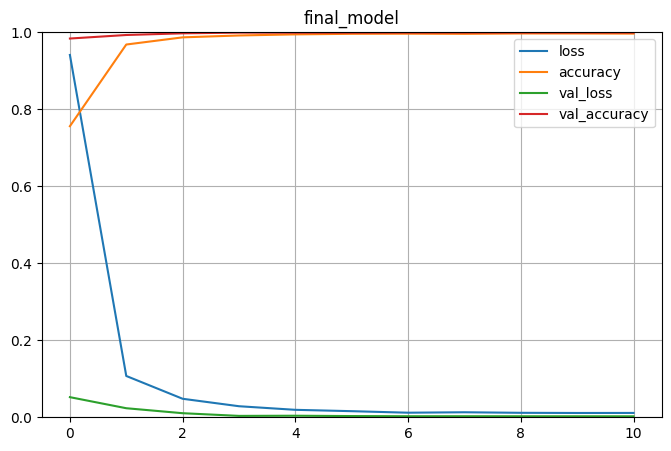

In [23]:
K.clear_session()
final_model = create_model(base_filters=32, kernel_size=(3,3), drop_rate=0.5, units=1024, padding="valid")
final_history = compile_and_fit(final_model)
print(f"Accuracy: {accuracy(final_model)}")
plot_history(final_history, "final_model")

## Classification report


In [24]:
from sklearn.metrics import classification_report

prediction = np.argmax(final_model.predict(X_test), axis=1)
print(classification_report(labels, prediction))

395/395 [==============================] - 7s 19ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.99      1.00      0.99       720
           2       0.99      1.00      1.00       750
           3       1.00      0.98      0.99       450
           4       1.00      0.99      0.99       660
           5       0.98      0.99      0.99       630
           6       0.99      0.99      0.99       150
           7       0.99      1.00      1.00       450
           8       1.00      0.99      1.00       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       1.00      0.97      0.99       420
          12       1.00      0.95      0.97       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.95      1.00      0.98       210
          16       1.00  

## Predictions on Test Data


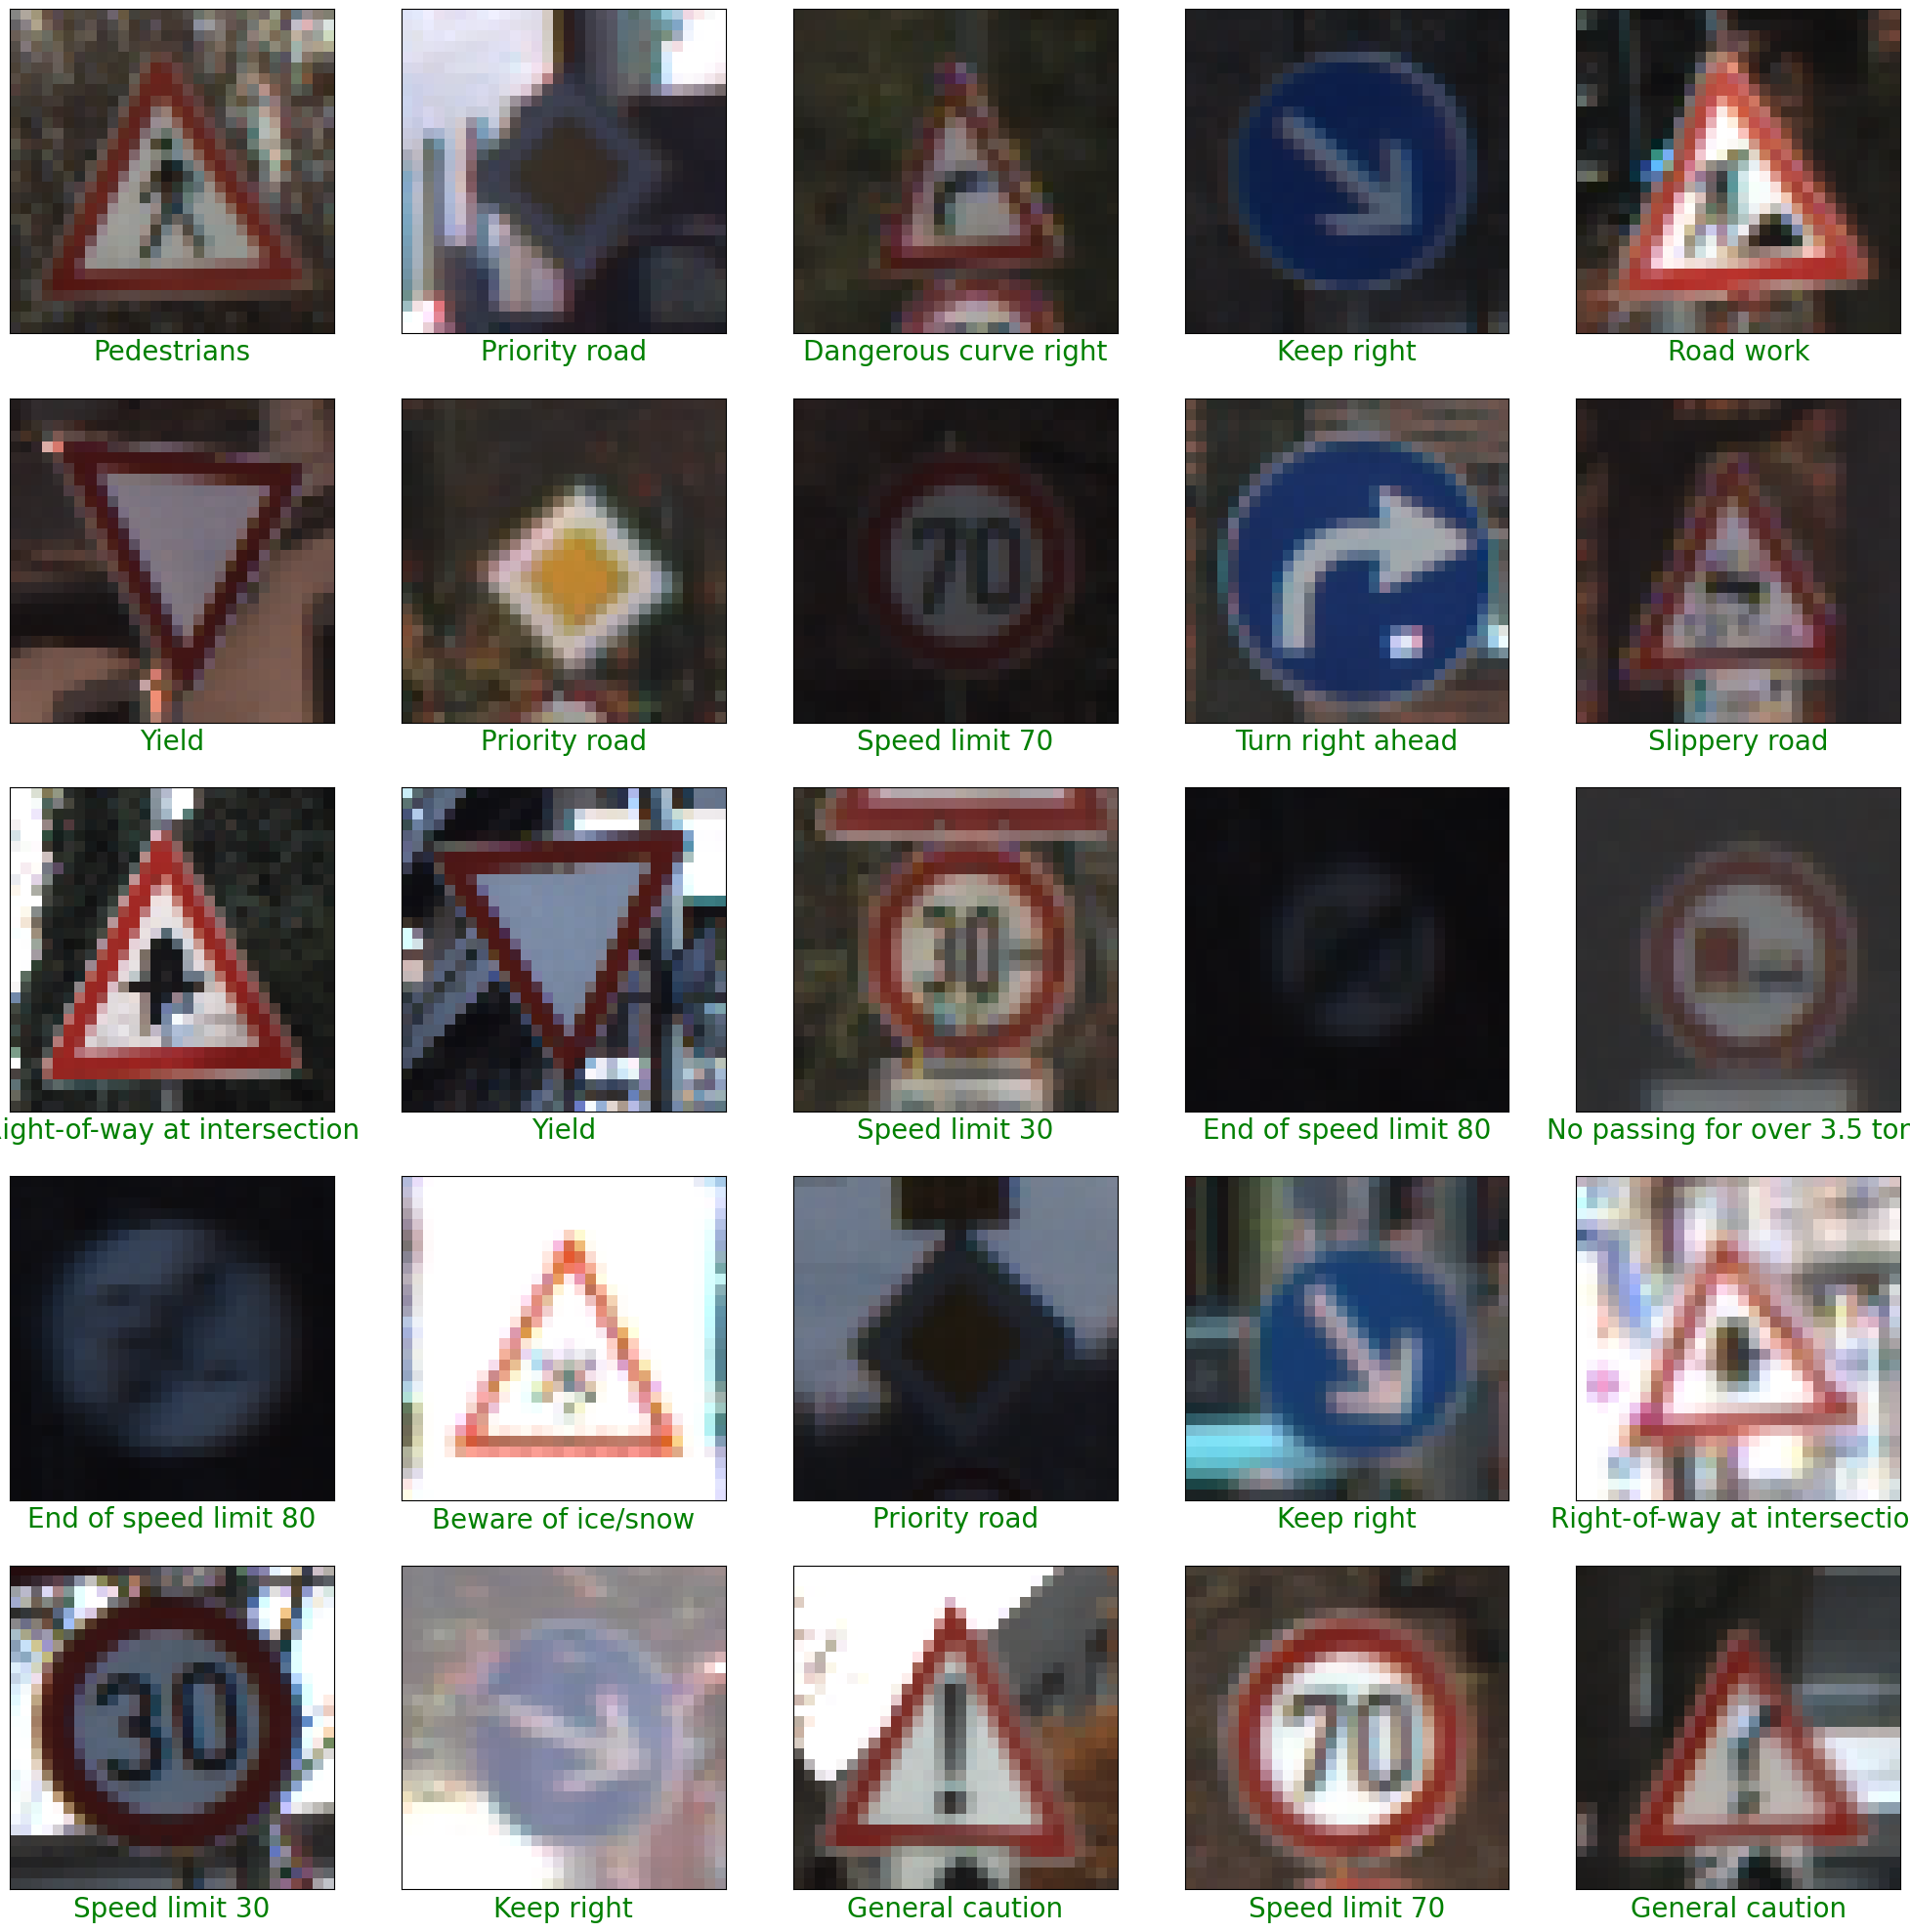

In [25]:
plt.figure(figsize=(25, 25))

start_index = 10000
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = prediction[start_index + i]
    actual = labels[start_index + i]
    col = "g"
    if pred != actual:
        col = "r"
    plt.xlabel("{}".format(classes[pred]), color=col, fontsize=20)
    plt.imshow(X_test[start_index + i])
plt.show()

# Save model


In [ ]:
final_model.save("models/final_model_without_roi.keras")

# Test the saving model


In [ ]:
def test_saving_model(path):
    reconstructed_model = keras.saving.load_model(path)
    predict_x = reconstructed_model.predict(X_test)  # return a 2D array
    result = np.argmax(predict_x, axis=1)  # Max index of each rows
    print("Accuracy: ", accuracy_score(labels, result) * 100)


test_saving_model("models/final_model.keras")

395/395 [==============================] - 52s 131ms/step
Accuracy:  99.15281076801267
